# TCN for oscillated part

In [3]:
from ray import train, tune

In [4]:
import torch
import torch.nn.functional as F
from torch.autograd import Variable
import torch.nn as nn
from torch.nn.utils import weight_norm
import torch.optim as optim
import numpy as np
from collections import OrderedDict
import os
import random
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from callback import tcn
from callback import earlystopping

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 乱数固定用の処理
# 同じ学習結果を得る
seed = 42


os.environ['PYTHONHASHSEED'] = str(seed)
# Python random
random.seed(seed)
# Numpy
np.random.seed(seed)
# Pytorch
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
# torch.cuda.manual_seed_all(seed)
torch.use_deterministic_algorithms = True
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## Data

In [6]:
def mk_dataframe(path):
    df = pd.read_table(path, sep=" ", header=None)
    df = df.drop(columns=0, axis=1)
    df = df.drop(columns=3, axis=1)
    return df

df = mk_dataframe("230724/pos-7.dat")

In [7]:
df_ = df.values

Text(0.5, 1.0, '230724/pos-7.dat \n oscillated')

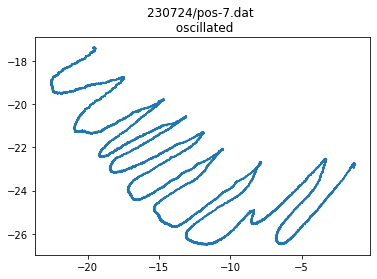

In [8]:
plt.plot(df_[:,0], df_[:,1])
plt.title("230724/pos-7.dat \n oscillated")

In [9]:
df_.shape

(36000, 2)

In [10]:
pos_by1sec = df_[::10]

In [11]:
pos_by1sec.shape[0]

3600

Text(0.5, 1.0, 'plot markers every 100 sec')

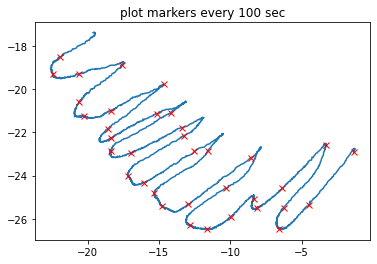

In [12]:
plt.plot(pos_by1sec[:,0], pos_by1sec[:,1])

for i in range(0, pos_by1sec.shape[0],100):
    plt.plot(pos_by1sec[i,0], pos_by1sec[i,1], marker="x", color="red")
    
plt.title("plot markers every 100 sec")

### Scaled

In [13]:
# 正規化
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0, 1))

pos_by1s_scaled = scaler.fit_transform(pos_by1sec)

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### time step

In [14]:
time_step = 300

len_seq = len(pos_by1s_scaled)
data_size = len_seq - time_step

data = np.zeros((data_size, 2, time_step))
t = np.zeros((data_size, 2))

In [15]:
for i in range(data_size):
    data[i,0] = pos_by1s_scaled[i:i+time_step, 0]
    data[i,1] = pos_by1s_scaled[i:i+time_step, 1]
    t[i] = pos_by1s_scaled[i+time_step]

### Tensor

In [16]:
# 使用するテンソル
x = torch.Tensor(np.array(data).reshape(-1, 2, time_step)).to(device)
t = torch.Tensor(np.array(t).reshape(-1, 2)).to(device)

In [17]:
n_seq = x.size(0)

train_size = int(n_seq * 0.9)
test_size = n_seq - train_size
print("train size:{}, test size: {}".format(train_size, test_size))
X_train, Y_train = x[:train_size], t[:train_size]
X_test, Y_test = x[train_size:], t[train_size:]

train size:2970, test size: 330


In [18]:
train_dataset = torch.utils.data.TensorDataset(X_train, Y_train)
test_dataset = torch.utils.data.TensorDataset(X_test, Y_test)

In [19]:
len(train_dataset)

2970

### Dataloader

In [131]:
def createDataloader(batch_size:int):
    train_dataloader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                         batch_size=batch_size, 
                                         shuffle=True, 
                                         num_workers=2)
    return train_dataloader

In [132]:
batch_size = 100

In [21]:
train_dataloader = createDataloader(batch_size)

In [22]:
len(train_dataloader)

30

In [23]:
for i, (x,t) in enumerate(train_dataloader):
        
    if i==1:
        break
    print("==============={}==============".format(i))
    print(x.shape)
    print(t.shape)

===============0==============
torch.Size([100, 2, 300])
torch.Size([100, 2])


## Train and Evaluate

In [24]:
def train_model(model, optimizer, batch_size: int=0, clip=-1):
    model.train()
    batch_idx = 1 # バッチが何回カウントされたか
    total_loss = 0
    
    for i, (x,t) in enumerate(train_dataloader):
        optimizer.zero_grad()
        output = model(x, debug=False)
        
        # 出力と正解の誤差をバッチの数で割る（バッチにおける誤差の平均）
        loss = F.mse_loss(output, t)
        loss.backward()
        if clip > 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        batch_idx += 1
        total_loss += loss.item()

        if batch_idx % 100 == 0:
            cur_loss = total_loss / batch_idx
            processed = min(i+batch_size, X_train.size(0))
            # print('Train Epoch: {:2d} [{:6d}/{:6d} ({:.0f}%)]\tLearning rate: {:.4f}\tLoss: {:.6f}'.format(
            #     epoch, processed, X_train.size(0), 100.*processed/X_train.size(0), lr, cur_loss))
            # total_loss = 0
            
    return total_loss / batch_idx
            
def evaluate(model, epoch=None, train_loss=None):
    model.eval()
    with torch.no_grad():
        test_loss = .0
        for i, (x,t) in enumerate(test_dataset):
            output = model(x.reshape(1,2,-1))
            t_loss = F.mse_loss(output, t.reshape(1,2))
            test_loss += t_loss.item()
            
        test_loss /= len(test_dataset)    

        if epoch % 5 == 0 or epoch == 1:
            print('\n [epoch: {}] Train loss: {:.6f} \t Test set: Average loss: {:.6f}\n'.format(epoch, train_loss, test_loss))
        
        return test_loss

In [25]:
for i, (x,t) in enumerate(test_dataset):
    if i != 0:
        break
    print(x.shape)

torch.Size([2, 300])


In [26]:
def trainWithTune(config):
    model = tcn.myTCN(input_size=2, 
                      output_size=2, 
                      num_channels=[15]*7, 
                      kernel_size=5, 
                      dropout=config["dropout"])
    model.to(device)
    optimizer = getattr(optim, 'Adam')(model.parameters(), lr=config["lr"])
    
    for i in range(10):
        train_model(model, optimizer, config["batch_size"])
        acc = evaluate(model)
        # Send the current training result back to Tune
        train.report({"mean_accuracy": acc})

        if i % 5 == 0:
            # This saves the model to the trial directory
            torch.save(model.state_dict(), "./model.pth")

In [68]:
search_space = {
    "dropout": tune.quniform(0.0, 0.5, 0.1),
    "lr": tune.sample_from(lambda spec: 10 ** (-10 * np.random.rand())),
    "batch_size": tune.choice([32, 64, 128, 256, 512]),
}

tuner = tune.Tuner(
    trainWithTune,
    param_space=search_space,
)
results = tuner.fit()

2023-11-17 17:21:06,242	WARNING worker.py:2074 -- Warning: The actor ImplicitFunc is very large (15 MiB). Check that its definition is not implicitly capturing a large array or other object in scope. Tip: use ray.put() to put large objects in the Ray object store.
2023-11-17 17:21:09,889	ERROR tune_controller.py:1383 -- Trial task failed for trial trainWithTune_40ee0_00000
Traceback (most recent call last):
  File "/home/ayuto/.local/lib/python3.10/site-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
  File "/home/ayuto/.local/lib/python3.10/site-packages/ray/_private/auto_init_hook.py", line 24, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/home/ayuto/.local/lib/python3.10/site-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "/home/ayuto/.local/lib/python3.10/site-packages/ray/_private/worker.py", line 2563, in get
    raise value.as_instanceof_cause

## Model

### param tuning

In [27]:
config = {
    'dropout': tune.quniform(0.0, 0.5, 0.1),
    'weight_decay': tune.qloguniform(1e-4, 1e-2, 5e-5),
    'batch_size': tune.choice([32, 64, 128, 256, 512]),
    'lr_init': tune.qloguniform(1e-3, 5e-1, 5e-4),
    'lr_gamma': tune.quniform(0.1, 1.0, 0.1),
    'lr_stepsize': tune.qrandint(10, 100, 5)
}

In [99]:
epochs = 30
lr = 1e-3
level = 7
h_dim = 20
kernel_size = 5

model = tcn.myTCN(input_size=2, output_size=2, num_channels=[h_dim]*level, kernel_size=kernel_size, dropout=0.0)
optimizer = getattr(optim, 'Adam')(model.parameters(), lr=lr)

In [100]:
loss = {"val_loss":[], "train_loss":[]}
es = earlystopping.EarlyStopping(patience=5, verbose=1)

for epoch in range(1, epochs + 1):
    train_loss = train_model(model, optimizer, clip=-1)
    tloss = evaluate(model, epoch, train_loss)
    
    loss["train_loss"].append(train_loss)
    loss["val_loss"].append(tloss)


 [epoch: 1] Train loss: 0.083040 	 Test set: Average loss: 0.205649


 [epoch: 5] Train loss: 0.000983 	 Test set: Average loss: 0.003551


 [epoch: 10] Train loss: 0.000145 	 Test set: Average loss: 0.001571


 [epoch: 15] Train loss: 0.000102 	 Test set: Average loss: 0.001949


 [epoch: 20] Train loss: 0.000056 	 Test set: Average loss: 0.001714


 [epoch: 25] Train loss: 0.000052 	 Test set: Average loss: 0.001475


 [epoch: 30] Train loss: 0.000042 	 Test set: Average loss: 0.001873



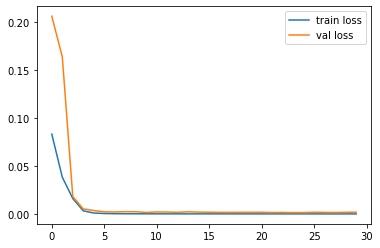

In [101]:
plt.plot(loss["train_loss"], label="train loss")
plt.plot(loss["val_loss"], label="val loss")
plt.legend()

## Model Save and Log

In [108]:
model_path = "model/tcn_epoch{}_level{}_hdim{}_ksize{}.pth".format(epochs, level, h_dim, kernel_size)
torch.save(model, model_path)

In [133]:
save_output = [{
    "model": "tcn",
    "batch size": batch_size,
    "time step": time_step,
    "epoch": epochs,
    "level": level,
    "hidden dim": h_dim,
    "kernel size": kernel_size,
    "learning rate": lr,
    "val loss": loss["val_loss"][-1],
    "model path": model_path,
}]

In [134]:
list(save_output[0])

['model',
 'batch size',
 'time step',
 'epoch',
 'level',
 'hidden dim',
 'kernel size',
 'learning rate',
 'val loss',
 'model path']

In [135]:
import csv

with open('model_log.csv','a') as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames = list(save_output[0]))
    writer.writeheader()
    writer.writerows(save_output)

## Prediction

In [127]:
def generate_pred(model, gen_time:int, z: torch.Tensor)-> list:
    gen = [[None, None] for i in range(time_step)]
    
    if type(z) != torch.Tensor:
        z = torch.Tensor(z)
        
    z = z.reshape(1,2,-1)
    
    for i in range(gen_time):
        model.eval()
        pred = model(z).data.cpu().numpy()
        z = np.concatenate([z.numpy().reshape(2,-1), pred.reshape(2,-1)], 1)
        z = z[:,1:]
        # print(z.shape)
        z = torch.Tensor(z.reshape(1,2,-1))
        gen.append([pred[0,0], pred[0,1]])
    
    return np.array(gen)

In [128]:
gen_time = len(data) - time_step

gen = [[None, None] for i in range(time_step)]
# z = X_test[0].reshape(1,2,-1)
z = torch.Tensor(data[0].reshape(1,2,-1))

for i in range(gen_time):
    model.eval()
    pred = model(z).data.cpu().numpy()
    z = np.concatenate([z.numpy().reshape(2,-1), pred.reshape(2,-1)], 1)
    z = z[:,1:]
    # print(z.shape)
    z = torch.Tensor(z.reshape(1,2,-1))
    gen.append([pred[0,0], pred[0,1]])

In [129]:
gen_time

3000

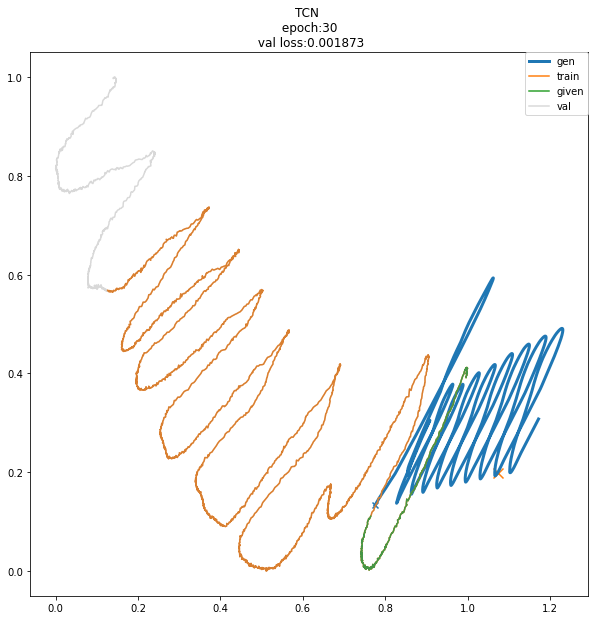

In [130]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10,10))
gen = np.array(gen)
plt.plot(gen[:,0], gen[:,1], label="gen", linewidth=3)
plt.scatter(gen[time_step,0], gen[time_step, 1], marker="x")
plt.scatter(gen[train_size,0], gen[train_size, 1], marker="x", s=100)


plot_train = X_train[:,:,0].numpy()
plt.plot(plot_train[:,0], plot_train[:,1], label="train")
# plt.plot(X_test[0,0], X_test[0,1], label="given")
plt.plot(pos_by1s_scaled[:time_step,0], pos_by1s_scaled[:time_step,1], label="given")
plt.plot(pos_by1s_scaled[:,0], pos_by1s_scaled[:,1], color="gray", alpha=0.3, label="val")
plt.title("TCN \n epoch:{} \n val loss:{:6f}".format(epochs, loss["val_loss"][-1]))
plt.legend(bbox_to_anchor=(1, 1), loc='upper right', borderaxespad=0)

(0.0, 1.0)

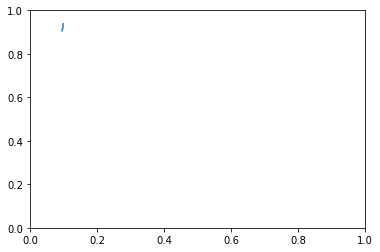

In [61]:
plt.plot(gen[train_size:,0], gen[train_size:,1])
plt.xlim(0,1)
plt.ylim(0,1)

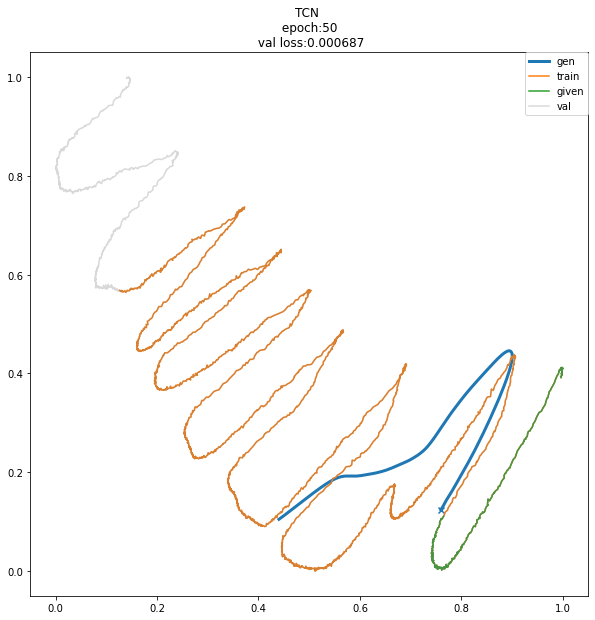

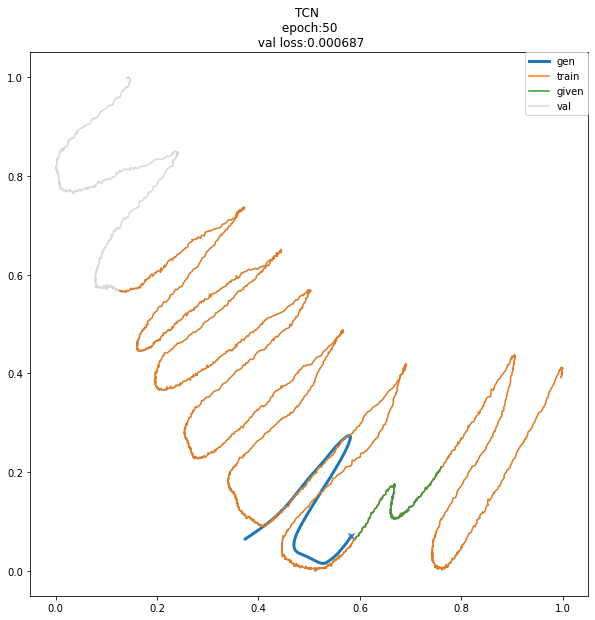

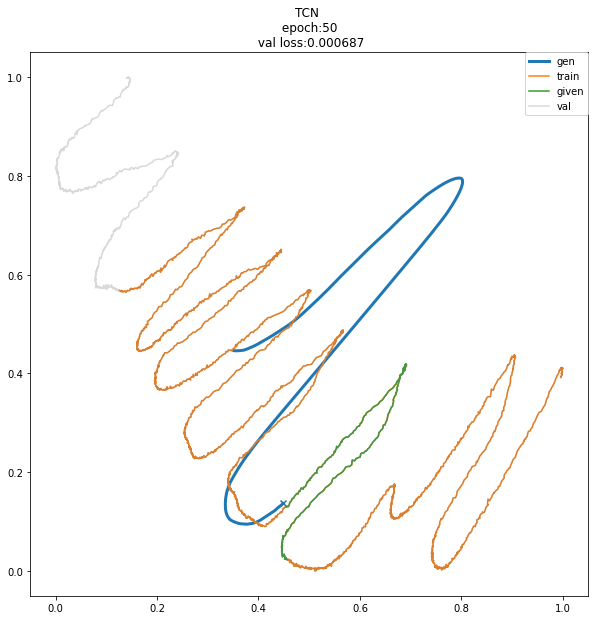

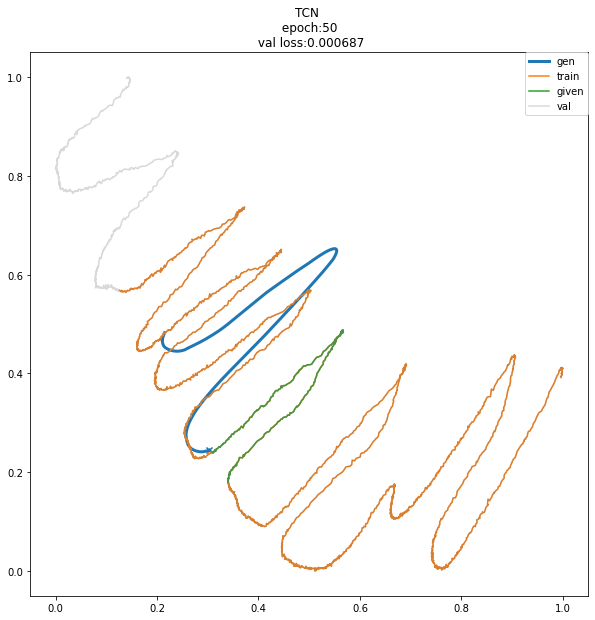

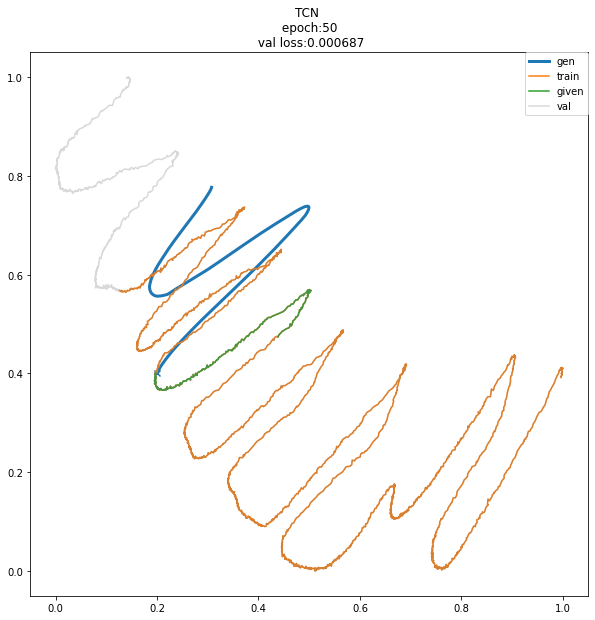

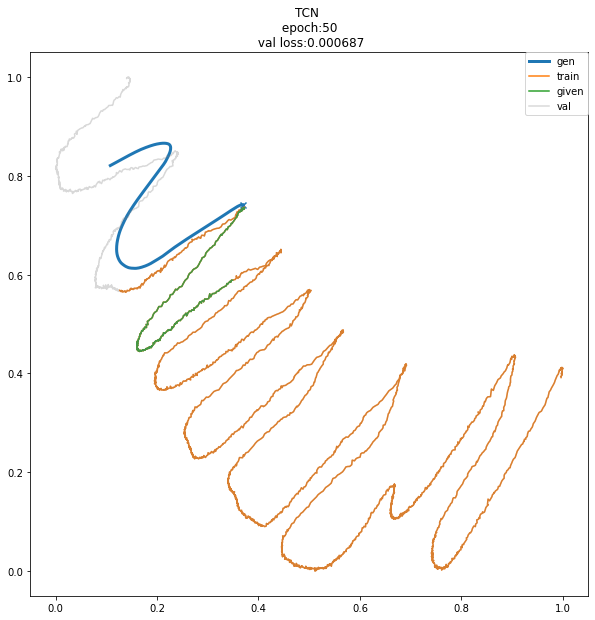

In [90]:
for i in range(0, 3000, 500):
    z_for_gen2 = data[i]
    gen2 = generate_pred(model, 500, z=z_for_gen2)

    plt.figure(figsize=(10,10))

    plt.plot(gen2[:,0], gen2[:,1], label="gen", linewidth=3)
    plt.scatter(gen2[time_step,0], gen2[time_step, 1], marker="x")


    plot_train = X_train[:,:,0].numpy()
    plt.plot(plot_train[:,0], plot_train[:,1], label="train")
    # plt.plot(X_test[0,0], X_test[0,1], label="given")

    plt.plot(z_for_gen2[0,:], z_for_gen2[1,:], label="given")


    plt.plot(pos_by1s_scaled[:,0], pos_by1s_scaled[:,1], color="gray", alpha=0.3, label="val")
    plt.title("TCN \n epoch:{} \n val loss:{:6f}".format(epochs, loss["val_loss"][-1]))
    plt.legend(bbox_to_anchor=(1, 1), loc='upper right', borderaxespad=0)

In [93]:
model_load = torch.load("model/epoch50_level7_hdim_20.pth")

In [94]:
genload = generate_pred(model_load, 500, z=data[0])

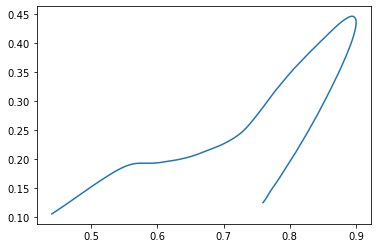

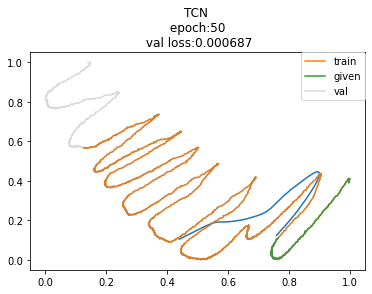

In [96]:
plt.plot(genload[:,0], genload[:,1])
plot_train = X_train[:,:,0].numpy()
plt.plot(plot_train[:,0], plot_train[:,1], label="train")
# plt.plot(X_test[0,0], X_test[0,1], label="given")
plt.plot(pos_by1s_scaled[:time_step,0], pos_by1s_scaled[:time_step,1], label="given")
plt.plot(pos_by1s_scaled[:,0], pos_by1s_scaled[:,1], color="gray", alpha=0.3, label="val")
plt.title("TCN \n epoch:{} \n val loss:{:6f}".format(epochs, loss["val_loss"][-1]))
plt.legend(bbox_to_anchor=(1, 1), loc='upper right', borderaxespad=0)

In [97]:
model_load

myTCN(
  (network): Sequential(
    (conv1_0): Conv1d(2, 20, kernel_size=(5,), stride=(1,), padding=(4,))
    (chomp1_0): Chomp1d()
    (relu1_0): ReLU()
    (dropout1_0): Dropout(p=0.0, inplace=False)
    (conv2_0): Conv1d(20, 20, kernel_size=(5,), stride=(1,), padding=(4,))
    (chomp2_0): Chomp1d()
    (relu2_0): ReLU()
    (dropout2_0): Dropout(p=0.0, inplace=False)
    (downsample_0): Conv1d(2, 20, kernel_size=(1,), stride=(1,))
    (relu_0): ReLU()
    (conv1_1): Conv1d(20, 20, kernel_size=(5,), stride=(1,), padding=(8,), dilation=(2,))
    (chomp1_1): Chomp1d()
    (relu1_1): ReLU()
    (dropout1_1): Dropout(p=0.0, inplace=False)
    (conv2_1): Conv1d(20, 20, kernel_size=(5,), stride=(1,), padding=(8,), dilation=(2,))
    (chomp2_1): Chomp1d()
    (relu2_1): ReLU()
    (dropout2_1): Dropout(p=0.0, inplace=False)
    (downsample_1): None
    (relu_1): ReLU()
    (conv1_2): Conv1d(20, 20, kernel_size=(5,), stride=(1,), padding=(16,), dilation=(4,))
    (chomp1_2): Chomp1d()
    (r